In [3]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
import pandas as pd

from importlib import reload

import integrator
reload(integrator)
from integrator import *

In [5]:
def init_simulation(theta, configs=default_configs):
    """
    Initializes a simulation object. The system's config needs to determined in `configs`.

    Focuses on period rather than semi-major axis.

    Reworked for 3 planets or more systems.
    """
    planet_num = configs['planet_num']
    planet_mass = configs['planet_mass']
    kappa = configs['kappa']
    C = configs['C']

    # if planet_num <= 2:
    #     raise Exception("The number of planets must be 3 or greater.")

    init_e = 10 ** np.array(theta[0:planet_num], dtype=np.float64)
    init_M = np.array(theta[planet_num:2*planet_num - 1])
    init_pomega = np.array(theta[2*planet_num - 1:3*planet_num - 2])

    # The index 0 corresponds to the 2nd (1) planet
    period_ratio_nom = np.zeros(planet_num-1)
    period_ratio_nom[0] = kappa

    period = np.zeros(planet_num)
    period[0] = 2*np.pi
    
    for i in range(1, planet_num):
        period[i] = period[i-1] * period_ratio_nom[i-1]

    # Initialize the simulation
    sim = rebound.Simulation()
    sim.add(m=1) # Primary star
    sim.add(m=planet_mass[0], P=period[0], pomega=0, M=0, e=init_e[0])
    for i in range(1, planet_num):
        sim.add(m=planet_mass[i], P=period[i], pomega=init_pomega[i-1], M=init_M[i-1], e=init_e[i])

    sim.move_to_com()
    
    return sim, theta, configs


def optimizing_function(theta, configs, vectorize=False):
    """
    Calculates the square of errors (as defined in the merit function)
    """
    sim, theta, configs = init_simulation(theta, configs)
    sim.move_to_hel()
    planet_num = configs['planet_num']
    kappa = configs['kappa']
    C = configs['C']

    init_theta = np.zeros((planet_num, 4))
    init_long = sim.particles[planet_num].theta
    for i in range(planet_num):
        x = sim.particles[i+1].x
        y = sim.particles[i+1].y
        vx = sim.particles[i+1].vx
        vy = sim.particles[i+1].vx
        init_theta[i, :] = [x, y, vx, vy]
        
    # Integrate
    integrate_one_cycle(sim, configs)
    sim.move_to_hel()

    final_theta = np.zeros((planet_num, 4))
    final_long = sim.particles[planet_num].theta

    long_diff = final_long - init_long
    
    for i in range(planet_num):
        # Transform final theta to be consistent with init theta
        x = sim.particles[i+1].x
        y = sim.particles[i+1].y
        pos_vec = np.array([x, y, 0])
        r = R.from_euler('z', -long_diff)
        pos_vec_transformed = r.apply(pos_vec)
        
        vx = sim.particles[i+1].vx
        vy = sim.particles[i+1].vx
        vel_vec = np.array([vx, vy, 0])
        r = R.from_euler('z', -long_diff)
        vel_vec_transformed = r.apply(vel_vec)
        
        cart_vec = np.array([pos_vec_transformed[:2], vel_vec_transformed[:2]]).flatten()
        
        final_theta[i, :] = cart_vec

    diff = final_theta - init_theta

    if vectorize:
        return diff
    else:
        return np.sum(diff ** 2)


def optimizing_function_keplerian(theta, configs, vectorize=False):
    """
    Calculates the square of errors (as defined in the merit function)
    """
    sim, theta, configs = init_simulation(theta, configs)
    planet_num = configs['planet_num']
    kappa = configs['kappa']
    C = configs['C']
    sim.move_to_hel()

    # The index 0 corresponds to the 2nd (1) planet
    period_ratio_nom = np.zeros(planet_num-1)
    period_ratio_nom[0] = kappa

    for i in range(1, planet_num - 1):
       period_ratio_nom[i] = (1+C[i-1]*(1-period_ratio_nom[i-1]))**(-1)

    # Initial Keplerian parameters
    init_e = np.log(np.array([sim.particles[i+1].e for i in range(planet_num)]))
    init_M = np.array([sim.particles[i+1].M for i in range(planet_num)])
    init_pomega = np.array([sim.particles[i+1].pomega for i in range(planet_num)])

    init_X = np.zeros(planet_num - 2)
    for i in range(0, len(init_X)):
        init_X[i] = sim.particles[i+3].P / sim.particles[i+2].P - period_ratio_nom[i+1] 

    # Integrate
    integrate_one_cycle(sim, configs)
    sim.move_to_hel()

    # Final Keplerian parameters
    final_e = np.log(np.array([sim.particles[i+1].e for i in range(planet_num)]))
    final_M = np.array([sim.particles[i+1].M for i in range(planet_num)])
    final_pomega = np.array([sim.particles[i+1].pomega for i in range(planet_num)])

    final_X = np.zeros(planet_num - 2)
    for i in range(0, len(init_X)):
        final_X[i] = sim.particles[i+3].P / sim.particles[i+2].P - period_ratio_nom[i+1] 

    e_diff = final_e - init_e
    M_diff = wrap_angle(final_M) - wrap_angle(init_M)
    X_diff = final_X - init_X

    pomega_diff = np.array([(final_pomega[i] - final_pomega[i+1]) - (init_pomega[i] - init_pomega[i+1]) for i in range(len(init_M) - 1)])

    diff = np.concatenate((e_diff, M_diff[1:], pomega_diff, X_diff)).flatten()
    diff = np.concatenate((e_diff, M_diff[1:], pomega_diff)).flatten()

    if vectorize:
        return diff
    else:
        return np.sum(diff ** 2)


def calculate_mse(theta, configs, vectorize=False, verbose=False):
    """
    Calculate mean square error of the given system after one cycle
    """
    sim, theta, configs = init_simulation(theta, configs)
    planet_num = configs['planet_num']

    sim.move_to_hel()
    init_long = sim.particles[1].theta
    init_distance = sim.particles[1].d
    cart_init = np.array([[sim.particles[i+1].x, sim.particles[i+1].y, sim.particles[i+1].z] for i in range(0, planet_num)])

    # Apply rotation
    r = R.from_euler('z', -init_long)
    cart_init = r.apply(cart_init)
    ref_cart_init = cart_init[0]
    # print(ref_cart_init)

    integrate_one_cycle(sim, configs)
    sim.move_to_hel()

    # Transform final to be consistent with init
    final_long = sim.particles[1].theta
    final_distance = sim.particles[1].d

    long_diff = final_long - init_long
    distance_diff = final_distance - init_distance
    
    # print(init_long, final_long)
    # print(final_distance, init_distance)

    cart_final = np.array([[sim.particles[i+1].x, sim.particles[i+1].y, sim.particles[i+1].z] for i in range(0, planet_num)])
    
    # Apply rotation
    r = R.from_euler('z', -final_long)
    cart_final = r.apply(cart_final)
    ref_cart_final = cart_final[0]
    # print(ref_cart_final)

    # Apply shift
    ref_diff = ref_cart_final - ref_cart_init

    # cart_final[:,0] -= ref_diff[0]
    # cart_final[:,1] -= ref_diff[1]

    cart_diff = cart_final - cart_init

    mse = np.zeros(planet_num)
    for i, pos in enumerate(cart_diff):
        mse[i] = np.sum([comp ** 2 for comp in pos])

    if vectorize:
        return mse
    else:
        if verbose:
            print(np.sum(mse), theta)
        return np.sum(mse)


In [4]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-4, 1e-4],
    'kappa': 2.000018,
    'rho': 1,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.02,
    'bisection_tol': 1e-9,
}

# MSE vs Kappa

In [4]:
kappa_cands = np.linspace(1.99, 2.01, 51)
kappa_results = np.zeros([len(kappa_cands), 4], dtype='object')
kappa_mse = np.zeros(len(kappa_cands))

mse_vs_kappa_res = pd.DataFrame(columns=['kappa', 'res', 'mse'])

for j, kappa in enumerate(kappa_cands):
    k_configs = default_configs.copy()
    k_configs['kappa'] = kappa

    # sim, theta, configs = init_simulation(init_theta, k_configs)

    init_theta = [-1, -1, np.pi, 0,]

    bounds = [(-10, -0.3),(-10, -0.3),
              (0, 2*np.pi), 
              (0, 2*np.pi),]
    
    prelim_res = minimize(calculate_mse, x0=init_theta, args=(k_configs,), bounds=bounds, method='SLSQP', tol=1e-8)
    prelim_res_2 = minimize(calculate_mse, x0=prelim_res.x, args=(k_configs,), bounds=bounds, method='Nelder-Mead', tol=1e-16)
    res = minimize(calculate_mse, x0=prelim_res_2.x, args=(k_configs,), bounds=bounds, method='SLSQP', tol=1e-16)
    
    mse_vs_kappa_res.loc[len(mse_vs_kappa_res)] = [kappa, res.x, res.fun]
    print(j, kappa, res.x, res.fun)
    

0 1.99 [-0.30325537 -0.30106377  3.36932972  1.06791763] 0.00043697676476697365
1 1.9904 [-0.30183819 -0.30000039  3.36647803  1.06668868] 0.0003877877370347556
2 1.9908 [-2.23461488 -0.30000007  3.17464418  1.14205171] 4.343089497383291e-11
3 1.9912 [-0.30085555 -0.30262386  3.37781324  1.04923631] 0.0003078867549952021
4 1.9916 [-0.30024743 -0.30069958  3.38179256  1.04108148] 0.00026485729180927544
5 1.992 [-0.30000363 -0.30000148  3.38756573  1.02908553] 0.0002272874058227706
6 1.9924 [-0.30000404 -0.30023645  3.38956662  1.02599065] 0.00019403530097173864
7 1.9928 [-0.30110972 -0.30029767  3.39315568  1.01360759] 0.0001627552874867921


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


8 1.9931999999999999 [-3.00014435e-01 -3.00000000e-01  3.85936622e+00  1.67087678e-17] 0.00021826310368119013
9 1.9936 [-3.02511416e-01 -3.01610729e-01  3.85915310e+00  6.00646369e-04] 0.00018316095126618898


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


10 1.994 [-0.30099362 -0.30000017  3.865429    0.00833093] 0.0001500769292818036
11 1.9944 [-0.30075109 -0.30041474  3.41469528  0.970456  ] 6.61090315368543e-05
12 1.9948 [-3.05260390e-01 -3.00031709e-01  3.87525772e+00  1.75412560e-05] 9.386252878265058e-05
13 1.9951999999999999 [-0.30003442 -0.30003629  3.42651286  0.94435721] 3.376904797084276e-05
14 1.9956 [-3.00000589e-01 -3.00000047e-01  3.88323378e+00  2.96248233e-03] 5.3442155686449336e-05
15 1.996 [-0.30031745 -0.30000031  3.44159936  0.90967793] 1.226264504630673e-05
16 1.9964 [-3.00450122e-01 -3.00007974e-01  3.89817549e+00  3.45028218e-06] 2.328006747314985e-05
17 1.9968 [-2.13661735e+00 -6.30527973e+00  1.74197151e-05  4.02881188e+00] 9.854471149979454e-07
18 1.9971999999999999 [-7.85830204e-01 -3.00000234e-01  4.30947457e+00  9.06940444e-06] 2.3623168622884865e-07


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


19 1.9975999999999998 [-3.00405626e-01 -6.88660963e-01  3.71516119e+00  4.64517421e-05] 9.591226492370766e-06
20 1.998 [-3.00000701e-01 -8.14168399e-01  3.63455567e+00  8.29272487e-06] 3.957200453592293e-06
21 1.9984 [-0.30000348 -1.06227465  3.50314497  0.00392062] 1.2470455294363179e-06
22 1.9988 [-0.30000528 -4.89455792  3.27000978  0.02773786] 9.54065182856793e-08
23 1.9991999999999999 [-3.05288865e-01 -1.07618687e+00  3.14121730e+00  9.29659438e-07] 7.210040744113015e-16
24 1.9995999999999998 [-2.81432158e+00 -4.75830863e+00  3.93485570e+00  3.79228670e-07] 9.80875440645859e-07
25 2.0 [-6.69746498e-01 -1.34912329e+00  3.14157551e+00  8.08309834e-05] 5.3322957872877066e-17


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


26 2.0004 [-0.75194633 -1.26469971  3.11283599  0.03212391] 1.7630073977494208e-12
27 2.0008 [-7.68113430e-01 -1.08949209e+00  3.14211316e+00  3.40373939e-04] 1.5683680004173474e-14
28 2.0012 [-8.48072615e-01 -1.10877856e+00  3.14275774e+00  1.78045440e-07] 1.7057943737190264e-13
29 2.0016 [-8.68387927e-01 -1.03324147e+00  3.14314416e+00  1.15689072e-05] 3.070491556501862e-13
30 2.002 [-0.85137159 -0.92180425  3.07877836  0.07319254] 5.186958919129279e-18
31 2.0023999999999997 [-9.77524666e-01 -1.04108767e+00  3.14394992e+00  9.63673702e-07] 4.714335416213615e-12
32 2.0027999999999997 [-1.00047581e+00 -1.00910809e+00  3.14433095e+00  1.39542638e-06] 8.57987480168017e-12
33 2.0031999999999996 [-9.24438057e-01 -8.70993492e-01  3.14457142e+00  9.87641524e-06] 5.293030555899708e-16
34 2.0036 [-1.05607662e+00 -9.79090664e-01  3.14503020e+00  1.37605346e-05] 2.937276652830429e-11
35 2.004 [-9.87051065e-01 -8.66440968e-01  3.14517842e+00  4.85609163e-05] 2.490006153715013e-12
36 2.0044 [-9.81

/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


47 2.0088 [-1.11555803e+00 -7.54393915e-01  3.14972008e+00  2.39657040e-04] 2.6900437779822274e-16


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


48 2.0092 [-1.12448461e+00 -7.49662904e-01  3.14999077e+00  3.80011894e-04] 2.570928430543803e-17
49 2.0096 [-1.13303444e+00 -7.45221383e-01  3.15071236e+00  1.44825574e-17] 1.1930676428698044e-17
50 2.01 [-1.14129315e+00 -7.40974621e-01  3.15110468e+00  1.46246821e-06] 2.9674158772340134e-16


Text(0.5, 0, 'kappa')

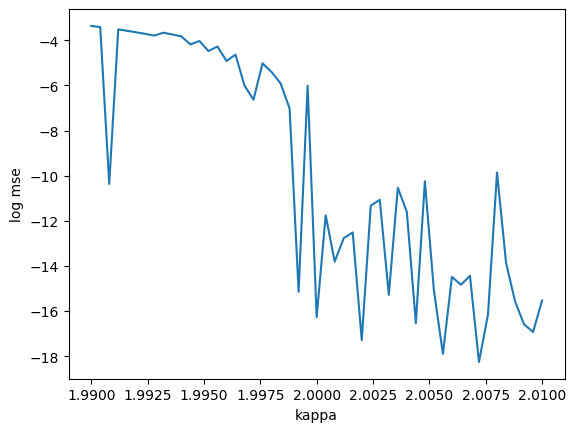

In [5]:
plt.plot(mse_vs_kappa_res['kappa'], np.log10(mse_vs_kappa_res['mse']))
plt.ylabel('log mse')
plt.xlabel('kappa')

Text(0.5, 1.0, 'pomega')

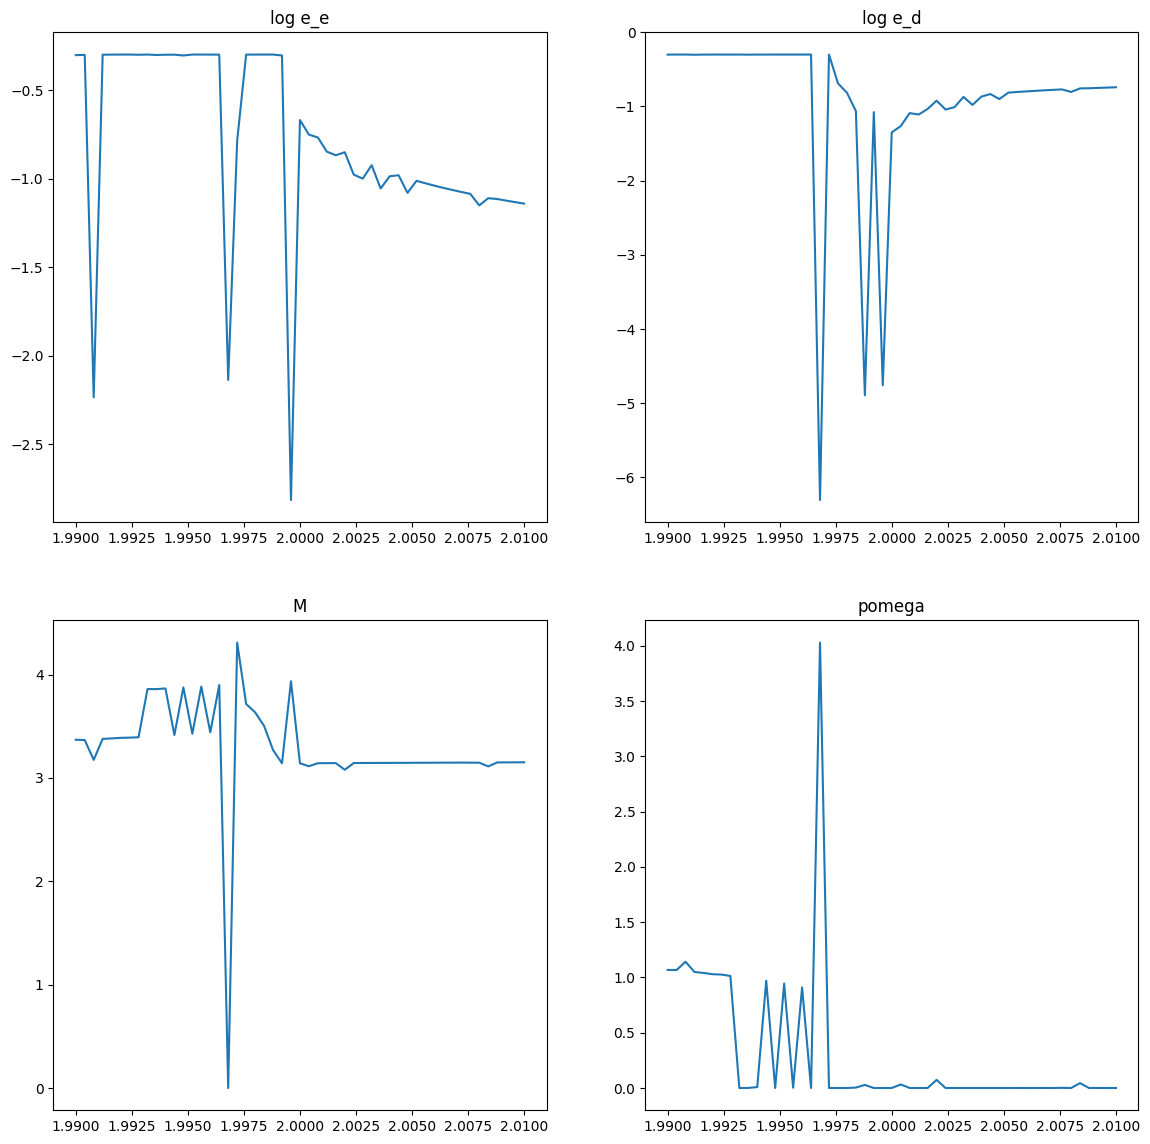

In [6]:
X_vs_kappa_df = np.vstack(mse_vs_kappa_res['res'])

plt.subplots(2, 2, figsize=(14, 14))
plt.subplot(2, 2, 1)
plt.plot(mse_vs_kappa_res['kappa'], X_vs_kappa_df[:,0])
plt.title('log e_e')

plt.subplot(2, 2, 2)
plt.plot(mse_vs_kappa_res['kappa'], X_vs_kappa_df[:,1])
plt.title('log e_d')

plt.subplot(2, 2, 3)
plt.plot(mse_vs_kappa_res['kappa'], X_vs_kappa_df[:,2])
plt.title('M')

plt.subplot(2, 2, 4)
plt.plot(mse_vs_kappa_res['kappa'], X_vs_kappa_df[:,3])
plt.title('pomega')


# PO Period vs Kappa

In [7]:
# PO period vs kappa

T_vs_kappa_df = pd.DataFrame(columns=['kappa', 'res', 'T'])

for i, (kappa, params) in enumerate(zip(mse_vs_kappa_res['kappa'], mse_vs_kappa_res['res'])):
    k_configs = default_configs
    k_configs['kappa'] = kappa
    
    sim, theta, configs = init_simulation(params, k_configs)
    _, T = integrate_one_cycle(sim, configs)
    T_vs_kappa_df.loc[len(T_vs_kappa_df)] = [kappa, params, T]
    print(T)


12.56352756500226
12.5635708999632
12.57746246337873
12.563785514831366
12.563754444122136
12.563801822662178
12.563835906982241
12.563943729400457
12.563930397033513
12.5639267921446
12.563991298675358
12.564257202148259
12.56390447616559
12.564459819793523
12.563936939239323
12.564746971130194
12.56390792846662
12.59006618499738
12.563269424438298
12.560699119567694
12.561281366348087
12.562317180633364
12.563402519225896
12.56412442326528
12.57220962524396
12.562631310371987
12.561823415756043
12.561430206298649
12.56025260925275
12.55962791442853
12.559322490691958
12.557079696655096
12.556160106658758
12.557114334106265
12.553942871093573
12.554929962158024
12.55456936836225
12.551646397113622
12.552822495996772
12.55194190502149
12.55105663299543
12.550157546996894
12.549262695312322
12.548367309570132
12.54743670463544
12.544672241210758
12.544769058227361
12.544720107316795
12.543799571990789
12.542886962890448
12.541963682478357


Text(0, 0.5, 'T diff from 4pi')

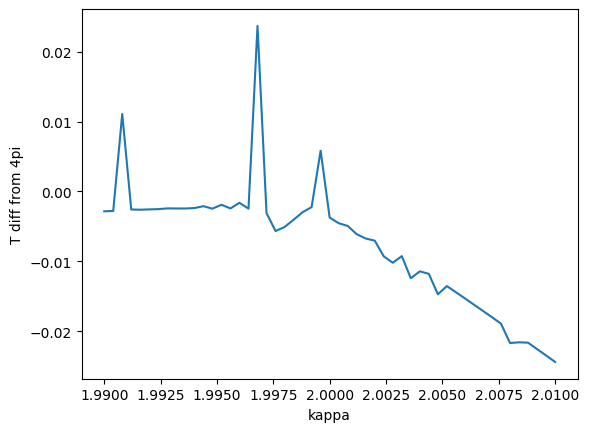

In [8]:
plt.plot(T_vs_kappa_df['kappa'], T_vs_kappa_df['T'] - 4 * np.pi)
plt.xlabel('kappa')
plt.ylabel('T diff from 4pi')

# Mass and Kappa

In [9]:
# PO Period vs mass

from sklearn.model_selection import ParameterGrid

mass_grid = {'mass_1': np.arange(1e-4, 101e-4, 10e-4),
             'mass_2': np.arange(1e-4, 101e-4, 10e-4),}

T_vs_m_res = pd.DataFrame(columns=['mass_1', 'mass_2', 'res', 'mse', 'T'])

default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-4, 1e-4],
    'kappa': 2.000018,
    'rho': 1,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.02,
    'bisection_tol': 1e-9,
}

for masses in ParameterGrid(mass_grid):
    m_configs = default_configs.copy()
    m_configs['planet_mass'] = [masses['mass_1'], masses['mass_2']]
    
    init_theta = [-1, -1, np.pi, 0,]

    bounds = [(-10, -0.3),(-10, -0.3),
              (0, 2*np.pi), 
              (0, 2*np.pi),]

    prelim_res = minimize(calculate_mse, x0=init_theta, args=(m_configs,), bounds=bounds, method='SLSQP', tol=1e-8)
    prelim_res_2 = minimize(calculate_mse, x0=prelim_res.x, args=(m_configs,), bounds=bounds, method='Nelder-Mead', tol=1e-16)
    res = minimize(calculate_mse, x0=prelim_res_2.x, args=(m_configs,), bounds=bounds, method='SLSQP', tol=1e-16)
    
    sim, theta, configs = init_simulation(res.x, m_configs)
    _, T = integrate_one_cycle(sim, configs)

    mse = calculate_mse(res.x, configs)
    
    T_vs_m_res.loc[len(T_vs_m_res)] = [masses['mass_1'], masses['mass_2'], res.x, mse, T]

    print(masses['mass_1'], masses['mass_2'], res.x, mse, T)
    print(m_configs)
    


0.0001 0.0001 [-6.72042600e-01 -1.33655244e+00  3.14158597e+00  9.06198676e-05] 7.948496656175108e-17 12.562610174193798
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


0.0001 0.0011 [-0.62216565 -2.54375927  3.11497854  0.02646372] 4.882286212404745e-17 12.529605693816958
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0011)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0001 0.0021 [-1.60267437 -0.54939679  2.72806542  0.07292485] 0.00018224990451388474 12.35584777832014
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0021)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0001 0.0031 [-6.02654108e-01 -2.29253303e+00  3.14167627e+00  1.86605493e-08] 2.5049142212910846e-12 12.467071666717356
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0031)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0001 0.0041 [-0.60675203 -2.77362225  3.10890826  0.03

/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


0.0011 0.0001 [-0.82324461 -1.27733905  3.09096863  0.04690952] 1.9731549414554113e-10 12.561000069975673
{'planet_num': 2, 'planet_mass': [np.float64(0.0011), np.float64(0.0001)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0011 0.0011 [-0.72699634 -1.6968094   3.12456686  0.0165528 ] 1.8269911390475623e-13 12.521626098001544
{'planet_num': 2, 'planet_mass': [np.float64(0.0011), np.float64(0.0011)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0011 0.0021 [-0.7058647  -2.33668556  2.97523498  0.16484118] 5.423604708162507e-18 12.486298522949042
{'planet_num': 2, 'planet_mass': [np.float64(0.0011), np.float64(0.0021)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0011 0.0031 [-3.38248636 -1.39036918  3.87515557  0.00583117] 0.00090

/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


0.0021 0.0001 [-7.88406510e-01 -1.14594331e+00  3.14155798e+00  7.30480556e-19] 4.6688534329312424e-11 12.561302185058416
{'planet_num': 2, 'planet_mass': [np.float64(0.0021), np.float64(0.0001)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0021 0.0011 [-0.79152    -1.70011585  3.03813282  0.10499214] 4.0524248964854165e-11 12.515184230804266
{'planet_num': 2, 'planet_mass': [np.float64(0.0021), np.float64(0.0011)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0021 0.0021 [-0.73630067 -1.76673981  3.09619336  0.04414679] 1.5310422333022003e-12 12.480663909911932
{'planet_num': 2, 'planet_mass': [np.float64(0.0021), np.float64(0.0021)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}


/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


0.0021 0.0031 [-5.01528744e-01 -9.11780720e-01  3.14892567e+00  6.40459886e-04] 3.665381162468321e-10 12.48375926971418
{'planet_num': 2, 'planet_mass': [np.float64(0.0021), np.float64(0.0031)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0021 0.0041 [-1.00000000e+01 -1.46034393e+00  3.90110670e+00  5.29185884e-08] 0.0016214811473872432 12.623770446777165
{'planet_num': 2, 'planet_mass': [np.float64(0.0021), np.float64(0.0041)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0021 0.0051 [-0.66810317 -1.77711905  3.09233597  0.04764523] 7.971901073673672e-17 12.387991895675485
{'planet_num': 2, 'planet_mass': [np.float64(0.0021), np.float64(0.0051)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0021 0.0061 [-9.97448742 -9.73422742  0.

/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


0.0031 0.0031 [-0.76163772 -2.14238203  2.90107912  0.2373283 ] 3.0383989354215825e-12 12.436351966857732
{'planet_num': 2, 'planet_mass': [np.float64(0.0031), np.float64(0.0031)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0031 0.0041 [-0.7277747  -1.95687179  2.9959168   0.14251241] 3.934551950693967e-15 12.40631376622693
{'planet_num': 2, 'planet_mass': [np.float64(0.0031), np.float64(0.0041)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0031 0.0051 [-0.72285848 -2.2849378   2.71444625  0.42287221] 6.188672409284706e-17 12.371995687484565
{'planet_num': 2, 'planet_mass': [np.float64(0.0031), np.float64(0.0051)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0031 0.0061 [-0.664224   -1.56486122  3.12313539  0.01748507] 9.4643849

/Users/chatszet/miniconda3/envs/pythenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


0.0091 0.0021 [-7.39254955e-01 -1.14165771e+00  3.14690586e+00  4.52054732e-04] 3.811315269047241e-08 12.47659486831369
{'planet_num': 2, 'planet_mass': [np.float64(0.0091), np.float64(0.0021)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0091 0.0031 [-1.77198434e+00 -3.61702070e+00  4.04666997e+00  6.13608095e-05] 0.0010034193248854792 12.730957565307436
{'planet_num': 2, 'planet_mass': [np.float64(0.0091), np.float64(0.0031)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0091 0.0041 [-3.00231792e-01 -5.71719334e-01  4.42895551e+00  8.69160653e-10] 0.0019045611262116474 12.612620897292908
{'planet_num': 2, 'planet_mass': [np.float64(0.0091), np.float64(0.0041)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
0.0091 0.0051 [-0.79448479

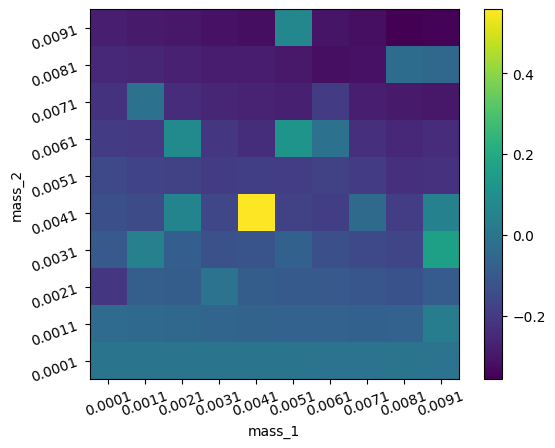

In [10]:
T_vs_m_plot = plt.imshow(np.array(T_vs_m_res.pivot(index='mass_2', columns='mass_1', values='T')) - 4 * np.pi, origin='lower')
plt.xlabel('mass_1')
plt.ylabel('mass_2')
plt.xticks(np.arange(0, 10, 1), labels=np.round(np.arange(1e-4, 101e-4, 10e-4), decimals=4), rotation=20)
plt.yticks(np.arange(0, 10, 1), labels=np.round(np.arange(1e-4, 101e-4, 10e-4), decimals=4), rotation=20)

plt.colorbar(T_vs_m_plot)

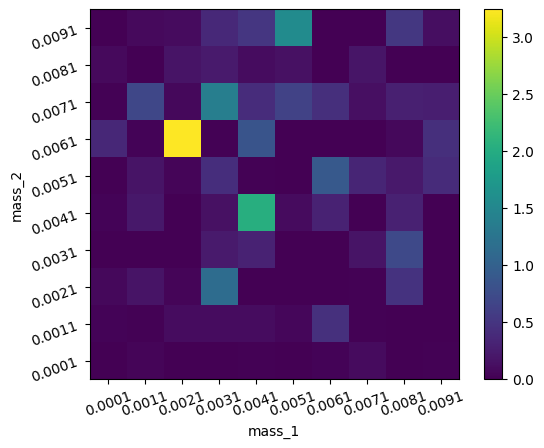

In [11]:
pomega_vs_m_res = T_vs_m_res.copy()
pomega_vs_m_res['res'] = pomega_vs_m_res['res'].apply(lambda x: x[3])

pomega_vs_m_plot = plt.imshow(pomega_vs_m_res.pivot(index='mass_2', columns='mass_1', values='res'), origin='lower')
plt.xlabel('mass_1')
plt.ylabel('mass_2')
plt.xticks(np.arange(0, 10, 1), labels=np.round(np.arange(1e-4, 101e-4, 10e-4), decimals=4), rotation=20)
plt.yticks(np.arange(0, 10, 1), labels=np.round(np.arange(1e-4, 101e-4, 10e-4), decimals=4), rotation=20)

plt.colorbar(pomega_vs_m_plot)

In [14]:
# T_vs_m_res.to_pickle('saved_vars/T_vs_m_res.pkl')

# Visualization

In [51]:
T_vs_m_res

,mass_1,mass_2,res,mse,T
0,0.0001,0.0001,"[-0.6720425995095043, -1.3365524421595636, 3.1...",7.948497e-17,12.562610
1,0.0001,0.0011,"[-0.6221656497103012, -2.543759267039648, 3.11...",4.882286e-17,12.529606
2,0.0001,0.0021,"[-1.6026743678409885, -0.5493967942730619, 2.7...",1.822499e-04,12.355848
3,0.0001,0.0031,"[-0.6026541083812301, -2.2925330328465683, 3.1...",2.504914e-12,12.467072
4,0.0001,0.0041,"[-0.6067520292650933, -2.773622253271676, 3.10...",9.591894e-18,12.435272
...,...,...,...,...,...
95,0.0091,0.0051,"[-0.7944847906569098, -1.6027886134181895, 2.7...",3.068133e-16,12.341568
96,0.0091,0.0061,"[-0.730094508473629, -1.324169980739404, 2.725...",3.762491e-17,12.327667
97,0.0091,0.0071,"[-0.7844591363348747, -1.842272084744223, 2.86...",2.104567e-16,12.269012
98,0.0091,0.0081,"[-1.5390998638982194, -1.1377224032552278, 3.8...",5.984798e-03,12.519744


In [52]:
res = pd.read_pickle('saved_vars/T_vs_m_res.pkl')
res = T_vs_m_res

{'planet_num': 2, 'planet_mass': [np.float64(0.0091), np.float64(0.0051)], 'kappa': 2.000018, 'rho': 1, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.02, 'bisection_tol': 1e-09}
12.341567582531283
[2.85891222e-09 1.72812004e-08]


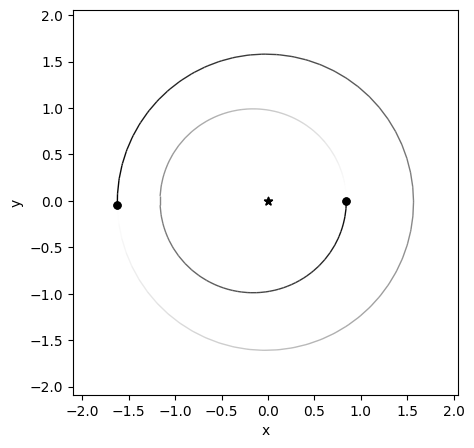

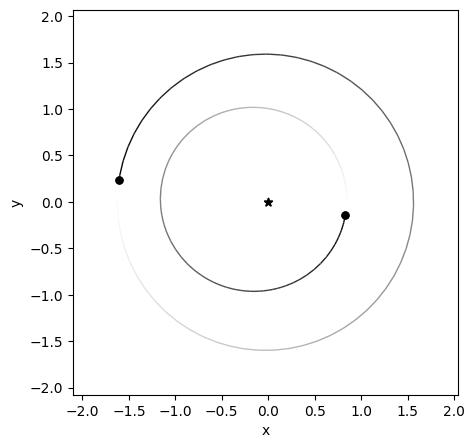

In [58]:
index = 95

now_configs = default_configs.copy()
now_configs['planet_mass'] = [res['mass_1'][index], res['mass_2'][index]]

print(now_configs)

sim, theta, configs = init_simulation(res['res'][index], now_configs)
rebound.OrbitPlot(sim)

sim, theta, configs = init_simulation(res['res'][index], now_configs)
_, target_time = integrate_one_cycle(sim, configs)
sim.integrate(target_time)
rebound.OrbitPlot(sim)
print(target_time)

print(np.sqrt(calculate_mse(res['res'][index], now_configs, True)))

In [54]:
target_time

12.341567582531283

In [59]:
result = res['res'][index]

sim, theta, configs = init_simulation(result, now_configs)
_, target_time = integrate_one_cycle(sim, configs)



marks = np.linspace(0, 10000, 10001)
hist = np.zeros(len(marks))
hist_P = np.zeros(len(marks))
hist_e_e = np.zeros(len(marks))
hist_lamb_d = np.zeros(len(marks))

for i, t in enumerate(marks):
    # print(t)
    # print(sim.t)
    sim.integrate(sim.t + target_time)
    # print(sim.t)
    sim.t = 0
    sim.move_to_hel()
    
    lamb_1 = sim.particles[1].l
    lamb_2 = sim.particles[2].l
    pomega_1 = sim.particles[1].pomega
    pomega_2 = sim.particles[2].pomega
    # lamb_3 = sim.particles[3].theta

    P_e = sim.particles[1].P
    P_d = sim.particles[2].P

    hist_lamb_d[i] = lamb_2

    angle = (lamb_1 - 2*lamb_2 + pomega_1)

    # print(sim.particles[1].M)
    
    hist[i] = angle

    hist_P[i] = P_d/P_e
    hist_e_e[i] = sim.particles[1].e

Text(0, 0.5, 'libration angle')

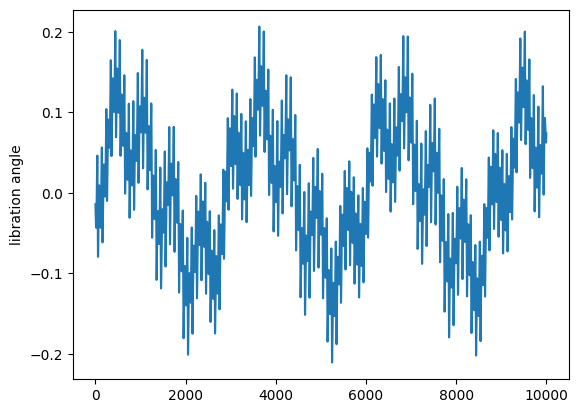

In [37]:
plt.plot(marks, wrap_angle(hist))
# plt.plot()
plt.ylabel('libration angle')

Text(0, 0.5, '$P_e/P_d$')

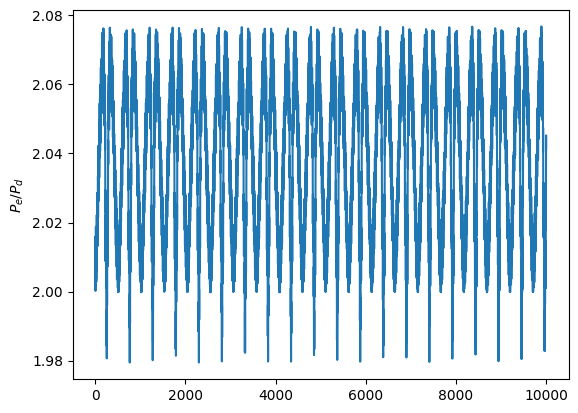

In [20]:
plt.plot(hist_P)
plt.ylabel(r'$P_e/P_d$')

Text(0, 0.5, '$e_e$')

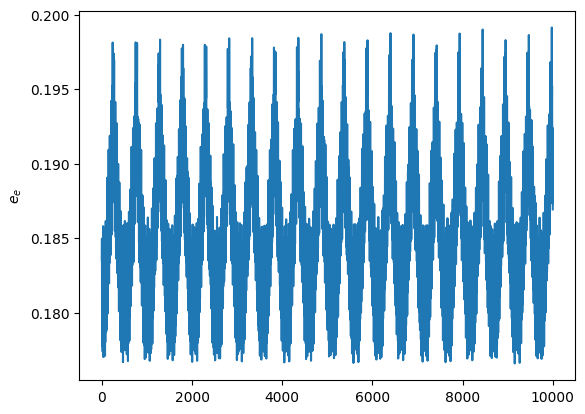

In [21]:
plt.plot(hist_e_e)
plt.ylabel(r'$e_e$')